In [1]:
%reset -f
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../code')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
# from scipy import signal
# import control
import scipy

from simulator import LinearSystemSimulator
from observability import ObservabilityMatrix
from observability import list_of_dicts_to_dict_of_lists
from observability import analytical_observability_gramian, get_matrix_rows_iterative, calculate_matrix_metrics

### Define system

In [2]:
# Set state-space matrices & system type
system_type = 'discrete' # 'continuous' or 'discrete', make sure this lines up with your choice of A & B matrices
measurement_type = 'linear' # linear = all states as outputs

A = np.eye(3)*0.9 # discrete
A[0, 2] = 4

B = np.array([[0.0],
              [0.0],
              [1.0]])

C = np.array([[1,2,3], [4,5,6]])


D = np.array([[0.0],
              [0.0]])

In [3]:
# system_type = 'continuous' # 'continuous' or 'discrete', make sure this lines up with your choice of A & B matrices
# measurement_type = 'linear' # linear = all states as outputs

# A = np.array([[0.0, 1.0],
#               [-1.0, -1.0]])

# B = np.array([[0.0],
#               [1.0]])

# C = np.array([[1.0, 0.0],
#               [0.0, 1.0]])

# D = np.array([[0.0],
#               [0.0]])

In [4]:
# Get sizes
n_state = A.shape[0]
n_input = B.shape[0]
n_output = C.shape[0]

### Simulate system

In [5]:
# Define system simulator object
sys = LinearSystemSimulator(A, B, C, D,
                            system_type=system_type,
                            measurement_type=measurement_type)

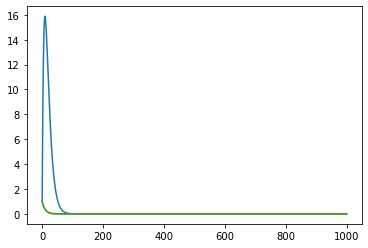

In [6]:
# Set time & input(s)
T = 1000 # total time [s]
fs = 1 # sampling rate [hz]
ts = 1 / fs # time step [s]

# Simulation time
tsim = np.arange(0, T, ts).T
n_point = tsim.shape[0]

# Simulation input
usim = np.zeros((len(tsim), 1))

# Initial conditions
x0 = np.array([[1], [3], [5]])
x0 = np.squeeze(np.ones((1,n_state)))

# Simulate
nominal_state, _ = sys.simulate(x0.T, tsim, usim, measurement_type, system_type=system_type)

# Plot
plt.plot(nominal_state['t'], nominal_state['x'])
plt.show()

### Observability matrix

In [7]:
# Set system & the nominal state trajectory to calculate empirical Observability Matrix (Oe)
Obsv = ObservabilityMatrix(sys, nominal_state['t'], nominal_state['x'], nominal_state['u'])
Oe, deltay = Obsv.calculate_O(x0.T, tsim, usim, eps=0.001)

pd.DataFrame(Oe)

,0,1,2
0,1.000000e+00,2.000000e+00,3.000000e+00
1,4.000000e+00,5.000000e+00,6.000000e+00
2,9.000000e-01,1.800000e+00,6.700000e+00
3,3.600000e+00,4.500000e+00,2.140000e+01
4,8.100000e-01,1.620000e+00,9.630000e+00
...,...,...,...
1995,9.590514e-46,1.198814e-45,4.251102e-42
1996,2.157866e-46,4.315731e-46,9.577807e-43
1997,8.631463e-46,1.078933e-45,3.829828e-42
1998,1.942079e-46,3.884158e-46,8.628658e-43


### Empirical Observability Gramian

In [8]:
We = Oe.T @ Oe
print('Empirical:')
pd.DataFrame(We)

Empirical:


,0,1,2
0,89.473684,115.789474,1837.396122
1,115.789474,152.631579,2383.379501
2,1837.396122,2383.379501,77399.110658


In [9]:
U, E, V = np.linalg.svd(Oe.T @ Oe)
print('Singular values:', E)
print('Condition #:', np.max(E) / np.min(E)) 

Singular values: [7.75163089e+04 1.23877449e+02 1.02957520e+00]
Condition #: 75289.60414354467


### Analytical Observability Gramian

In [10]:
Wo = analytical_observability_gramian(A, C, system_type, n_derivatives=n_point)
print('Analytical:')
pd.DataFrame(Wo)

Analytical:


,0,1,2
0,89.473684,115.789474,1837.396122
1,115.789474,152.631579,2383.379501
2,1837.396122,2383.379501,77399.110658


## See how Gramian evolves over time

In [11]:
# In this method I collect multiple rows (# of rows collected = # of outputs) of Oe at each time step, 
# This smooths out the curves
O_over_time, metrics = get_matrix_rows_iterative(Oe, 
                                                 stepsize=n_output, 
                                                 subfunction=calculate_matrix_metrics)

print(metrics.keys())

W3d = np.dstack(metrics['W'][:]) # Gramian over time in 3rd dimension

print(W3d.shape)
print(tsim.shape)
print(len(metrics['condition_number']))

dict_keys(['W', 'condition_number', 'min_singular_value', 'max_singular_value', 'E'])
(3, 3, 1000)
(1000,)
1000


### Plot elements of Gramian & condition # over time

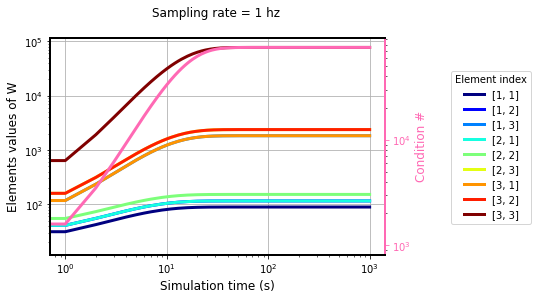

In [12]:
# Plot
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

xaxis_data = 'time' # 'time or 'points'
if xaxis_data == 'time':
    xplot = tsim
    xlabel = 'Simulation time (s)'
elif xaxis_data == 'points':
    xplot = np.arange(0, len(tsim), 1)
    xlabel = 'Simulation points'
else:
    raise Exception("xaxis_data type not valid")
    
cmap = cm.get_cmap('jet')
cmap = cmap(np.linspace(0, 1, sys.n*n_state))
cindex = 0
for r in range(n_state):
    for c in range(n_state):
        ax.plot(xplot, W3d[r,c,:], 
                label= '[' + str(r+1) + ', ' + str(c+1) + ']',
                color=cmap[cindex],
                lw=3)
        cindex =  cindex + 1
        
fig.legend(loc='center right', bbox_to_anchor =(1.25, 0.5), title='Element index')
ax.set_xlabel(xlabel, fontsize=12)
ax.set_ylabel('Elements values of W', fontsize=12)
ax.set_title('Sampling rate = ' + str(fs) + ' hz \n')
ax.grid()

# Condition number
ax2color = 'hotpink'
ax2 = ax.twinx()  
ax2.plot(xplot, metrics['condition_number'], '-', color=ax2color, lw=3)
ax2.set_ylabel('Condition #', color=ax2color, fontsize=12)
ax2.spines['right'].set_color(ax2color)
ax2.tick_params(axis="y", colors=ax2color)

ax.set_xscale('log')
ax.set_yscale('log')
ax2.set_yscale('log')

for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(2)


### Comparison with Floris's method of adding each row of Oe at a time

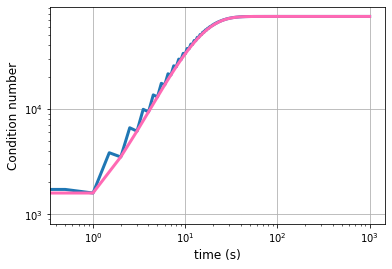

In [13]:
CNs = []
for i in range(3, Oe.shape[0]):
    U, E, V = np.linalg.svd(Oe[0:i,:].T @ Oe[0:i,:])
    CNs.append(np.max(E) / np.min(E))

fig = plt.figure()
ax = fig.add_subplot(111)
tsim_gramian = np.linspace(0, T, len(CNs))
ax.plot(tsim_gramian, CNs, lw=3)
ax.plot(tsim, metrics['condition_number'], '-', color=ax2color, lw=3)

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylabel('Condition number', fontsize=12)
ax.set_xlabel('time (s)', fontsize=12)

ax.grid()

# Jagged points are from adding only part of the data at each time step